(page:rdf)=
# Radial Distribution Function

This script calculates the Radial Distribution Function (RDF) from atomic coordinates. Adapted from a simple 3D RDF code found at sicmm.org as well as from the implementation in [ASE](https://wiki.fysik.dtu.dk/ase/_modules/ase/geometry/analysis.html#Analysis.get_rdf).


Here, we analyze the RDF of a clean particle. However, feel free to change the `n_O` value below to analyze systems with more oxygen atoms, as we did in the [main article](https://doi.org/10.48550/arXiv.2303.03746). First, read in the data.

In [14]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

Choose a system with 0 oxygen atoms.

In [15]:
from asetools.systemtools import read_bgf

sample = data.loc[(data["n_O"] == 0)].iloc[0]
atoms = read_bgf(sample["root"])

RDF is a *pair* distribution function. Hence, we need to define which atomic pairs should be analyzed. Here, we only use the Pt atoms as the `probe`, as already implied by the choice of the non-oxidized test system.

In [16]:
probe = "Pt"

Just like in the case of the [oxidation state analysis](page:oxidation_state) or the [adsorbate density analysis](page:adsorbate_density), the RDF is a radial density analysis. We will therefore go through very similar steps, defining a `binwidth`, determining the `center` of the structure and the maximum distance in the system `dmax`, and finally determine the number of bins `nbins` from these values.

In [17]:
import numpy as np

binwidth = 0.1
center = np.sum(atoms.get_positions(), axis=0) / len(atoms)

indices = [atom.index for atom in atoms if atom.symbol == probe]
dists = np.linalg.norm(atoms[indices].get_positions() - center, axis=1)

dmax = max(dists)
nbins = int(dmax / binwidth)

bins = [0] * (nbins + 1)

The key difference to the earlier implementations is, however, that we will not use the distance-to-center values to perform the analysis. These values are only used to determine `dmax` and `nbins`. In the following, we will calculate the distance between all atomic pairs involving `probe` atoms which will be the basis for the analysis.

We will use this this opportunity to compare three different ways to perform these distance calculations.

The first implementation will be very literal and straight-forward. It uses two nested `for` loops that will map out all possible permutations of atomic pair. The first `for` loop iterates through all atomic indices up until - but not including - the last one. The second, inner `for` loop iterates from the atomic index after the current index produced by the first `for` loop until the very last index. This way we produce combinations of all atom pairs without double counting, and save some CPU cycles since we're not calculating the same distances twice.

In [18]:
from time import perf_counter

dists = []
indices = [atom.index for atom in atoms if atom.symbol == probe]

# Time at start.
tstart = perf_counter()

# Perform distance calculations.
for i, atom1 in enumerate(atoms[indices][:-1]):
    for atom2 in atoms[indices][i + 1:]:
        dist = np.linalg.norm(atom2.position - atom1.position)
        dists.append(dist)

# Time at end.
tend = perf_counter()

print("Required time: ", tend - tstart, "seconds")

Required time:  0.5782933340015006 seconds


If you had a chance to hear a lecture on `python` programming at some point, you've probably heard that nested `for` loops should be avoided since they are rather inefficient. We can test this advice here by exploiting `numpy` broadcasting operations again to convert the nested `for` loop into a single `for` loop. To this end, we make use of the `ase.Atoms.get_distances` function, which conveniently implements such an operation under the hood. 

The function `ase.Atoms.get_indices` accepts a list of atomic indices as the second argument which will be used to calculate distances to the single atomic index passed as the first argument.

In [19]:
dists_fast = []
indices = [atom.index for atom in atoms if atom.symbol == probe]

# Time at start.
tstart = perf_counter()

# Perform distance calculations.
for i, idx in enumerate(indices[:-1]):
    tmp_dists = atoms.get_distances(idx, indices[i + 1:])
    dists_fast.extend(tmp_dists)

# Time at end.
tend = perf_counter()

print("Required time: ", tend - tstart, "seconds")

Required time:  0.025682367999252165 seconds


With this fix, the calculation finished in about 4 % of the original time!

Besides speed, using the ASE function provides another convenient feature. If we pass `mic = True` to `ase.Atoms.get_distances`, the code will take into account [periodic boundary conditions and the minimum-image convention](https://en.wikipedia.org/wiki/Periodic_boundary_conditions#Practical_implementation:_continuity_and_the_minimum_image_convention), allowing us to calculate the pair distances correctly in systems with periodic boundaries.

Let's get greedy though - can we optimize this even futher? There is a function called `ase.Atom.get_all_distances` which does exactly what it says.

In [20]:
dists_superfast = []
indices = [atom.index for atom in atoms if atom.symbol == probe]

# Time at start.
tstart = perf_counter()

dists_superfast = atoms[indices].get_all_distances()

# Time at end.
tend = perf_counter()

print("Required time: ", tend - tstart, "seconds")

Required time:  0.011892212998645846 seconds


By eliminating the second `for` loop as well, we were able to reduce the runtime by about factor 2. While not as much of a gain as the last optimiztion, these improvements quickly add up when calculating RDFs for thousands of MD images with large model systems. `ase.Atoms.calculate_all_distances`, too, will accept the `mic = True` keyword for correct treatment of distances in periodic systems.

This last optimization, however, has one small caveat: it does not avoid double counting, *i.e.*, we obtain distances for both atom1 to atom2 and atom2 to atom1, which are identical. It also calculates self-interaction distances between atoms with themselves. We can quickly check that this is true:

In [21]:
print(len(dists_fast))
print(len(dists_superfast.flatten()))

119316
239121


We perform the `flatten` operation on the distance array since `ase.Atoms.calculate_all_distances` returns an array-of-arrays where each array holds the distances of one atom with all other atoms. While undesired here, we will make use of this output structure during the implementation of the [powder XRD spectrum prediction](page:xrd).

In fact, we actually need both distances for the RDF evaluation but usually we would only calculate it once and count it as 2 occurrences. In production code, one would need to evaluate the speed gains from the above code against the potential loss in efficiency from having to double-process distances in the next code cell. For brevity, we will now continue with the larger `dists_superfast` results array and leave further testing as an exercise for the reader.

The remaining steps are similar to the [adsorbate density analysis](page_adsorbate_density). Loop through all distances and calculate which bin they fall into. Because `ase.Atoms.calculate_all_distances` calculates all distances, including those between the same atoms, there exist zero-distances which need to be filtered out.

In [22]:
for d in dists_superfast.flatten():
    if d > 0:
        thisbin = int(d / binwidth)
        if thisbin <= nbins:
            bins[thisbin] += 1

Finally, the distribution needs to be normalized with regards to the number density `rho` and the volume of the sphere segments.

In [23]:
vol = atoms.get_volume()
ncnt = len(indices)
rho = ncnt / vol
norm = 4 * np.pi * rho * ncnt

for i, value in enumerate(bins):
    rr  = (i - 0.5) * binwidth
    value /= (norm * rr * rr * binwidth)
    bins[i] = value

Visualize the distribution using `pyplot`.

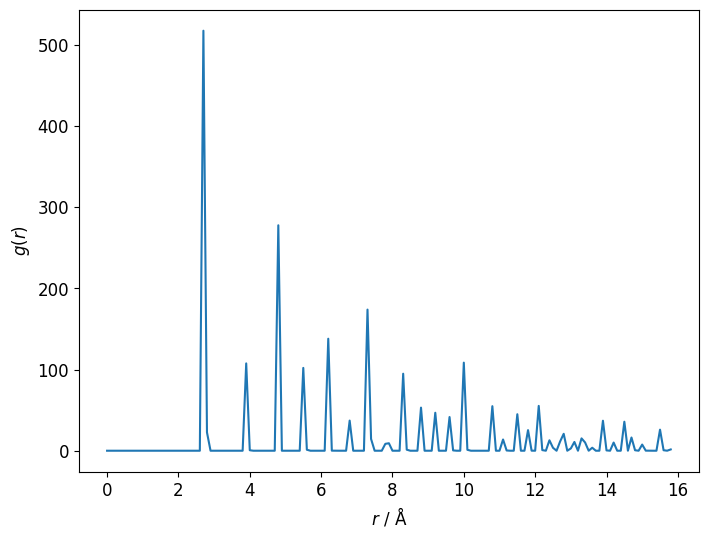

In [24]:
import matplotlib.pylab as plt

x = []
y = []
for i, val in enumerate(bins):
    x.append(i * binwidth)
    y.append(val)

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(x, y)
plt.xlabel("$r$ / $\mathrm{\AA}$")
plt.ylabel("$g(r)$")
plt.show()

The RDF shows that the most common distance is *ca.* 2.8 Å, which is the distance between neighboring Pt atoms. It also shows distinct peaks, indicating a high degree of structural order. Change the system at the beginning of this page to a more oxidized one to see the impact on the RDF!